In [1]:
import time
import numpy as np
import tensorflow as tf
import utils

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

In [3]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

In [6]:
from collections import Counter
import random
threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

In [7]:
def get_target(words, idx, window_size=5):
    rndm = np.random.randint(1, window_size+1)
    if (idx - rndm) > 0:
        k = idx - rndm
    else: 
        k=0
    l = idx + rndm + 1
    target_words = set(words[k:idx] + words[idx+1:l])
    
    return list(target_words)

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [9]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name="inputs")
    labels = tf.placeholder(tf.int32, [None, None], name="labels")

In [10]:
n_vocab = len(int_to_vocab)
n_embedding =  200
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

In [11]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1)) 
    softmax_b = tf.Variable(tf.zeros(n_vocab), name="softmax_bias")
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(
        weights=softmax_w,
        biases=softmax_b,
        labels=labels,
        inputs=embed,
        num_sampled=n_sampled,
        num_classes=n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [12]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [13]:
!mkdir checkpoints

Џ®¤Ї ЇЄ  Ё«Ё д ©« checkpoints г¦Ґ бгйҐбвўгҐв.


In [14]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.6335 0.5852 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.6310 0.5762 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.5274 0.5781 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.6069 0.5810 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.5246 0.5950 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5037 0.6031 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.5580 0.5900 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5381 0.5928 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.4567 0.5932 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.4154 0.5940 sec/batch
Nearest to while: circumnavigate, riba, herrera, garten, invitation, upanishads, entablature, flagellar,
Nearest to such: philatelic, accusation, geologic, astral, daunting, millionaire, recombined, adoring,
Nearest to four: oecd, consumers, wcl, occultation, suspend, doors, mimosa, uppercamelcase,

Nearest to question: golconda, impregnated, heterogeneity, election, synapses, costumed, elastic, infection,
Nearest to taking: some, shoghi, laurie, broker, mills, thz, sydney, periodically,
Nearest to engineering: escherichia, landscape, accusers, handicap, oubangui, forgiving, defendant, somehow,
Nearest to primarily: michelin, crass, subjectivity, emeric, unfaithful, hereford, oxymoron, faure,
Nearest to ocean: doubly, instructor, dhekelia, deals, vld, sequitur, islander, requiring,
Nearest to frac: cdot, keanu, codices, eaters, uniform, functional, chaired, goldwater,
Nearest to bill: durand, aphorisms, norwegian, unconscious, crossing, filmography, consciously, boingo,
Epoch 1/10 Iteration: 4100 Avg. Training loss: 4.6833 0.5638 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 4.6735 0.5625 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 4.6186 0.5584 sec/batch
Epoch 1/10 Iteration: 4400 Avg. Training loss: 4.6191 0.5555 sec/batch
Epoch 1/10 Iteration: 4500 Avg. 

Nearest to seven: two, three, one, zero, five, m, fong, under,
Nearest to there: divided, village, heathens, leeward, unabated, since, derivational, tune,
Nearest to united: yemen, resolution, pennington, dollars, thule, hle, accused, signatory,
Nearest to his: wrote, eminently, abiathar, he, spent, starred, marry, elektra,
Nearest to on: bahrain, dusty, toilets, longitude, altered, edging, abandoned, casting,
Nearest to alternative: perturbation, ascanius, viable, giza, wipes, jainism, priesthoods, deciding,
Nearest to question: golconda, heterogeneity, impregnated, costumed, debased, regalia, debates, know,
Nearest to taking: shoghi, some, prophetess, thz, alexius, dimensionless, destabilizing, broker,
Nearest to engineering: forgiving, oubangui, escherichia, jarama, mathematics, lus, negativity, isoroku,
Nearest to primarily: michelin, emeric, crass, economies, dependency, or, integrates, unfaithful,
Nearest to ocean: sea, hutongs, satellite, classis, islander, equator, sequitur, sp

Epoch 3/10 Iteration: 11700 Avg. Training loss: 4.1908 0.5527 sec/batch
Epoch 3/10 Iteration: 11800 Avg. Training loss: 4.1817 0.5514 sec/batch
Epoch 3/10 Iteration: 11900 Avg. Training loss: 4.1550 0.5556 sec/batch
Epoch 3/10 Iteration: 12000 Avg. Training loss: 4.1787 0.5491 sec/batch
Nearest to while: than, riba, circumnavigate, herrera, entablature, flagellar, breakage, infringes,
Nearest to such: critiques, astral, pep, investigated, loads, downgraded, contraindicated, interpolating,
Nearest to four: zero, three, five, six, nine, eight, years, one,
Nearest to seven: two, three, one, five, zero, nine, fong, nevil,
Nearest to there: divided, axiom, multiplying, leeward, are, tune, since, backronym,
Nearest to united: signatory, dollars, yemen, pennington, states, thule, negotiated, presidents,
Nearest to his: abiathar, wrote, he, eminently, spent, bafta, elektra, niece,
Nearest to on: longitude, bahrain, toilets, casting, edging, deciphering, about, clementine,
Nearest to alternativ

Nearest to bill: meditators, snoopy, maclennan, leopards, ted, sidebar, carlin, boingo,
Epoch 4/10 Iteration: 15100 Avg. Training loss: 4.0505 0.5639 sec/batch
Epoch 4/10 Iteration: 15200 Avg. Training loss: 4.0561 0.5561 sec/batch
Epoch 4/10 Iteration: 15300 Avg. Training loss: 4.0043 0.5561 sec/batch
Epoch 4/10 Iteration: 15400 Avg. Training loss: 4.0727 0.5515 sec/batch
Epoch 4/10 Iteration: 15500 Avg. Training loss: 4.0725 0.5571 sec/batch
Epoch 4/10 Iteration: 15600 Avg. Training loss: 4.0752 0.5568 sec/batch
Epoch 4/10 Iteration: 15700 Avg. Training loss: 4.0757 0.5539 sec/batch
Epoch 4/10 Iteration: 15800 Avg. Training loss: 4.0878 0.5530 sec/batch
Epoch 4/10 Iteration: 15900 Avg. Training loss: 4.0433 0.5558 sec/batch
Epoch 4/10 Iteration: 16000 Avg. Training loss: 4.0314 0.5519 sec/batch
Nearest to while: inability, entablature, breakage, riba, circumnavigate, infringes, plight, than,
Nearest to such: interpolating, critiques, lessen, cooperatives, converting, contraindicated,

Nearest to question: know, think, vien, fallacy, heterogeneity, debates, disenchanted, locus,
Nearest to taking: some, costing, alexius, dimensionless, gastrointestinal, keokuk, destabilizing, thz,
Nearest to engineering: sciences, mathematics, landscape, development, forgiving, jarama, amplification, aerodynamics,
Nearest to primarily: emeric, michelin, integrates, coleoptera, hoe, dysfunctions, pda, or,
Nearest to ocean: intersputnik, hutongs, atlantic, inmarsat, equator, kiribati, satellite, axel,
Nearest to frac: cdot, sqrt, geq, momentum, goldwater, ldots, uniform, bundles,
Nearest to bill: meditators, snoopy, leopards, maclennan, ted, appointees, carlin, sidebar,
Epoch 5/10 Iteration: 19100 Avg. Training loss: 3.9881 0.5602 sec/batch
Epoch 5/10 Iteration: 19200 Avg. Training loss: 3.9460 0.5495 sec/batch
Epoch 5/10 Iteration: 19300 Avg. Training loss: 4.0204 0.5448 sec/batch
Epoch 5/10 Iteration: 19400 Avg. Training loss: 4.0195 0.5495 sec/batch
Epoch 5/10 Iteration: 19500 Avg. T

Nearest to four: zero, three, five, six, nine, eight, one, two,
Nearest to seven: one, three, zero, two, nine, five, four, eight,
Nearest to there: since, tune, are, operators, participate, australopithecus, letterboxes, minkowski,
Nearest to united: states, signatory, whitehaven, dollars, yemen, winners, presidents, kubitschek,
Nearest to his: he, wrote, spent, abiathar, had, niece, ascanio, elektra,
Nearest to on: longitude, in, the, about, clementine, wormhole, is, deciphering,
Nearest to alternative: viable, perturbation, trumpeter, quash, curves, convective, giza, jainism,
Nearest to question: know, think, vien, debates, heterogeneity, fallacy, equivocation, submissive,
Nearest to taking: some, costing, peritoneum, appealing, dimensionless, keokuk, alexius, thz,
Nearest to engineering: sciences, mathematics, landscape, forgiving, development, escherichia, amplification, aerodynamics,
Nearest to primarily: coleoptera, emeric, michelin, dysfunctions, or, mix, tripolitania, hoe,
Near

Epoch 6/10 Iteration: 26800 Avg. Training loss: 4.0042 0.5527 sec/batch
Epoch 6/10 Iteration: 26900 Avg. Training loss: 3.9715 0.5483 sec/batch
Epoch 6/10 Iteration: 27000 Avg. Training loss: 3.9952 0.5442 sec/batch
Nearest to while: inability, secession, immediately, rowley, baptismal, still, circumnavigate, gear,
Nearest to such: as, syngman, roots, lessen, also, including, considered, interpolating,
Nearest to four: three, zero, five, six, eight, nine, one, two,
Nearest to seven: three, two, one, zero, five, nine, four, eight,
Nearest to there: are, since, tune, participate, who, operators, embarrass, have,
Nearest to united: states, signatory, whitehaven, winners, u, yemen, war, sanction,
Nearest to his: he, wrote, spent, abiathar, had, niece, doctorate, elektra,
Nearest to on: longitude, in, clementine, and, wallabies, toilets, about, the,
Nearest to alternative: viable, trumpeter, perturbation, quash, jainism, subcontinent, giza, zs,
Nearest to question: know, think, vien, debate

Epoch 7/10 Iteration: 30400 Avg. Training loss: 3.8639 0.5476 sec/batch
Epoch 7/10 Iteration: 30500 Avg. Training loss: 3.9275 0.5472 sec/batch
Epoch 7/10 Iteration: 30600 Avg. Training loss: 3.9231 0.5437 sec/batch
Epoch 7/10 Iteration: 30700 Avg. Training loss: 3.9044 0.5486 sec/batch
Epoch 7/10 Iteration: 30800 Avg. Training loss: 3.9133 0.5467 sec/batch
Epoch 7/10 Iteration: 30900 Avg. Training loss: 3.9187 0.5559 sec/batch
Epoch 7/10 Iteration: 31000 Avg. Training loss: 3.8791 0.5534 sec/batch
Nearest to while: immediately, inability, pneuma, rowley, secession, flexi, although, baptismal,
Nearest to such: as, also, considered, lessen, syngman, roots, pep, including,
Nearest to four: three, zero, six, five, eight, two, one, nine,
Nearest to seven: three, two, one, zero, five, nine, four, six,
Nearest to there: are, since, have, who, operators, tune, shou, participate,
Nearest to united: states, u, signatory, whitehaven, winners, yemen, cooperatives, dollars,
Nearest to his: he, had

Epoch 8/10 Iteration: 34200 Avg. Training loss: 3.8734 0.5506 sec/batch
Epoch 8/10 Iteration: 34300 Avg. Training loss: 3.9275 0.5515 sec/batch
Epoch 8/10 Iteration: 34400 Avg. Training loss: 3.9117 0.5474 sec/batch
Epoch 8/10 Iteration: 34500 Avg. Training loss: 3.8657 0.5472 sec/batch
Epoch 8/10 Iteration: 34600 Avg. Training loss: 3.8859 0.5476 sec/batch
Epoch 8/10 Iteration: 34700 Avg. Training loss: 3.8800 0.5472 sec/batch
Epoch 8/10 Iteration: 34800 Avg. Training loss: 3.9227 0.5469 sec/batch
Epoch 8/10 Iteration: 34900 Avg. Training loss: 3.8859 0.5544 sec/batch
Epoch 8/10 Iteration: 35000 Avg. Training loss: 3.8978 0.5566 sec/batch
Nearest to while: immediately, falling, pneuma, more, although, a, lays, which,
Nearest to such: also, as, of, include, including, considered, expensive, lessen,
Nearest to four: three, zero, five, six, eight, one, two, nine,
Nearest to seven: one, three, two, zero, nine, five, four, eight,
Nearest to there: are, have, since, is, who, not, myoglobin,

Epoch 9/10 Iteration: 38200 Avg. Training loss: 3.7615 0.5495 sec/batch
Epoch 9/10 Iteration: 38300 Avg. Training loss: 3.8023 0.5507 sec/batch
Epoch 9/10 Iteration: 38400 Avg. Training loss: 3.7730 0.5496 sec/batch
Epoch 9/10 Iteration: 38500 Avg. Training loss: 3.8199 0.5510 sec/batch
Epoch 9/10 Iteration: 38600 Avg. Training loss: 3.8645 0.5511 sec/batch
Epoch 9/10 Iteration: 38700 Avg. Training loss: 3.8406 0.5509 sec/batch
Epoch 9/10 Iteration: 38800 Avg. Training loss: 3.8421 0.5535 sec/batch
Epoch 9/10 Iteration: 38900 Avg. Training loss: 3.8669 0.5554 sec/batch
Epoch 9/10 Iteration: 39000 Avg. Training loss: 3.8802 0.5574 sec/batch
Nearest to while: more, a, immediately, although, had, pneuma, adjusted, falling,
Nearest to such: also, as, including, of, include, considered, restricted, various,
Nearest to four: three, six, zero, five, eight, two, one, nine,
Nearest to seven: one, three, two, zero, five, nine, eight, four,
Nearest to there: are, have, since, myoglobin, is, inter

Epoch 10/10 Iteration: 42200 Avg. Training loss: 3.8341 0.5476 sec/batch
Epoch 10/10 Iteration: 42300 Avg. Training loss: 3.7862 0.5456 sec/batch
Epoch 10/10 Iteration: 42400 Avg. Training loss: 3.8443 0.5511 sec/batch
Epoch 10/10 Iteration: 42500 Avg. Training loss: 3.8414 0.5474 sec/batch
Epoch 10/10 Iteration: 42600 Avg. Training loss: 3.8354 0.5453 sec/batch
Epoch 10/10 Iteration: 42700 Avg. Training loss: 3.8828 0.5473 sec/batch
Epoch 10/10 Iteration: 42800 Avg. Training loss: 3.7416 0.5508 sec/batch
Epoch 10/10 Iteration: 42900 Avg. Training loss: 3.8012 0.5525 sec/batch
Epoch 10/10 Iteration: 43000 Avg. Training loss: 3.7850 0.5523 sec/batch
Nearest to while: a, the, immediately, although, more, which, had, pneuma,
Nearest to such: also, as, including, of, are, include, the, considered,
Nearest to four: three, zero, six, five, eight, two, one, nine,
Nearest to seven: one, three, two, nine, five, zero, eight, six,
Nearest to there: are, since, have, is, any, not, for, to,
Nearest

In [15]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints\text8.ckpt


In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [17]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

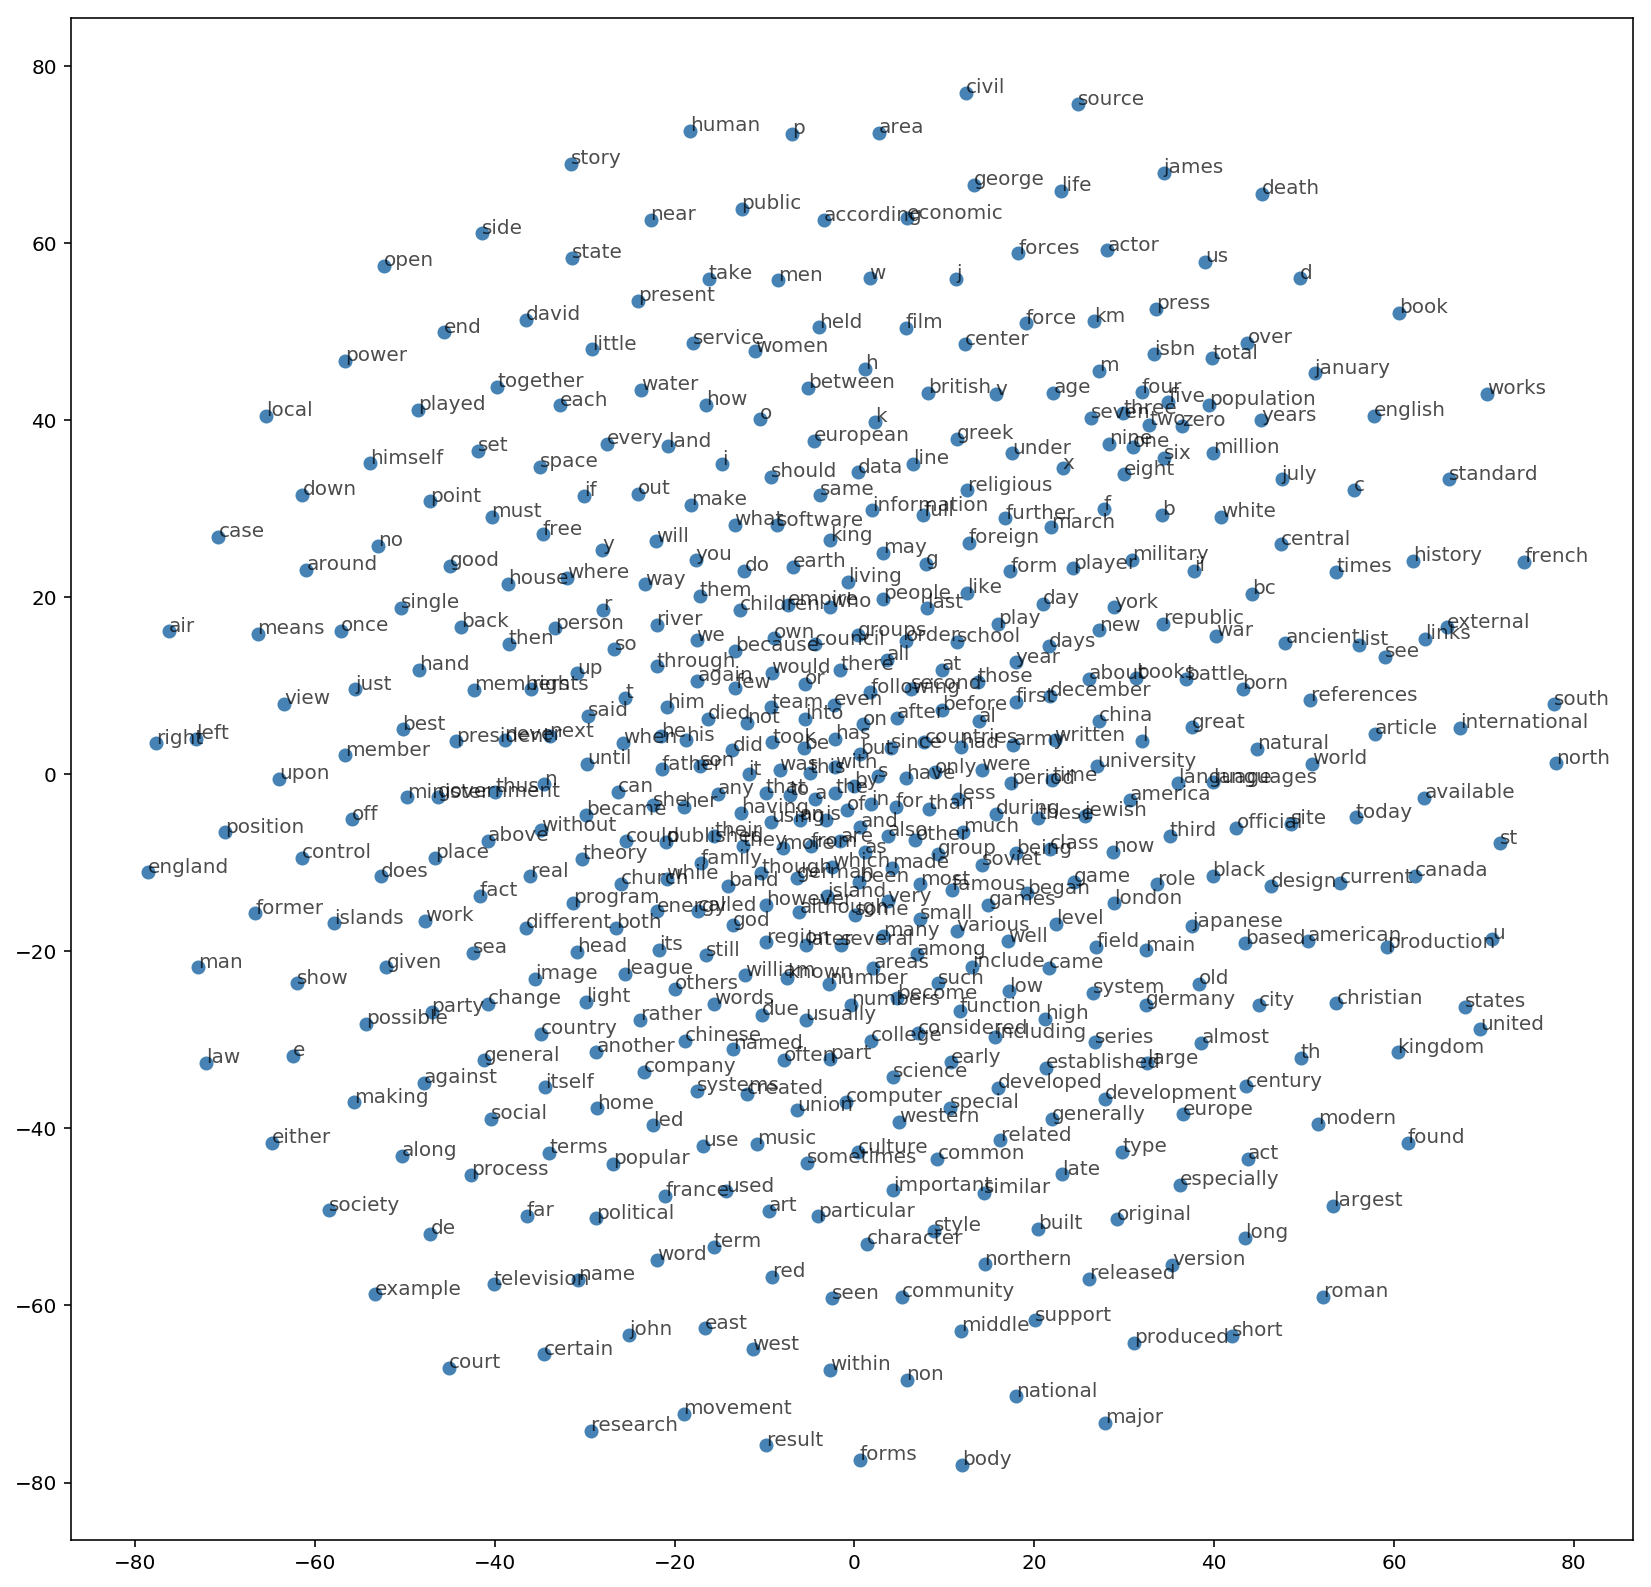

In [18]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)